# Projet 5: Segmentez des clients d'un site e-commerce

## Nettoyage et analyse exploratoire.

### Sommaire

- <a href="#C1">Description de la mission</a>

- <a href="#C2">Importation du jeu de données</a>

- <a href="#C3">Stabilité temporelle de la segmentation</a>

In [2]:
%load_ext pycodestyle_magic

ModuleNotFoundError: No module named 'pycodestyle_magic'

In [2]:
%pycodestyle_on

## <a name ='C1'>Description de la mission</a>

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.


Après quelques premières analyses, vous vous rendez compte qu’Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l’entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission. Voici sa réponse

## <a name='C2'> Importation du jeu de données<a/>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import homogeneity_score, adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import metrics
from matplotlib import cm
from time import time
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from kmodes.kprototypes import KPrototypes

## <a name='C2'> Création du DataFrame<a/>

In [4]:
df_order = pd.read_csv('../olist_orders_dataset.csv')
df_order = df_order[['customer_id', 'order_purchase_timestamp']]
df_order

,customer_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39
...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27


In [5]:
df_custom = pd.read_csv('../olist_customers_dataset.csv')
df_custom = df_custom[['customer_id', 'customer_unique_id']]
df_custom

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e


In [6]:
df_temp = df_order.merge(df_custom,
                         left_on='customer_id',
                         right_on='customer_id')

In [7]:
df_temp

,customer_id,order_purchase_timestamp,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c


In [8]:
df_temp = df_temp.drop_duplicates(subset=['customer_unique_id'], keep='last')

In [9]:
df_temp

,customer_id,order_purchase_timestamp,customer_unique_id
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6
5,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05,80bb27c7c16e8f973207a5086ab329e2
...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c


L'année la plus récente qu'on a dans ce jeu de donnée est donc 2016. On va créer un compte de mois qui commence à janvier 2016.

Pour certains clients on a plusieurs date de commande, on va juste garder la dernière. 

In [10]:
df_rfm = pd.read_csv('rfm').drop(columns='Unnamed: 0')

In [11]:
df_temp = df_temp.drop(columns='customer_id')

In [12]:
df_rfm = df_temp.merge(df_rfm,
                       left_on='customer_unique_id',
                       right_on='customer_unique_id')

In [13]:
df_rfm['date'] = df_rfm['order_purchase_timestamp']

In [14]:
df_rfm = df_rfm.drop(columns='order_purchase_timestamp')

In [15]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93396 non-null  object 
 1   Recency             93396 non-null  int64  
 2   Frequency           93396 non-null  int64  
 3   Monetary            93396 non-null  float64
 4   date                93396 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.3+ MB


In [16]:
df_rfm.to_csv('temp_data')

On transforme la colonne au type date

In [17]:
df_rfm['date'] = pd.to_datetime(df_rfm['date'], format='%Y-%m-%d %H:%M:%S')

In [18]:
df_rfm

,customer_unique_id,Recency,Frequency,Monetary,date
0,af07308b275d755c9edb36a90c618231,41,1,141.46,2018-07-24 20:41:37
1,3a653a41f6f9fc3d2a113cf8398680e8,26,1,179.12,2018-08-08 08:38:49
2,7c142cf63193a1473d2e66489a9ae977,289,1,72.20,2017-11-18 19:28:06
3,72632f0f9dd73dfee390c9b22eb56dd6,202,1,28.62,2018-02-13 21:18:39
4,80bb27c7c16e8f973207a5086ab329e2,421,1,175.26,2017-07-09 21:57:05
...,...,...,...,...,...
93391,6359f309b166b0196dbf7ad2ac62bb5a,543,1,85.08,2017-03-09 09:54:05
93392,da62f9e57a76d978d02ab5362c509660,209,1,195.00,2018-02-06 12:58:58
93393,737520a9aad80b3fbbdad19b66b37b30,372,1,271.01,2017-08-27 14:46:43
93394,5097a5312c8b157bb7be58ae360ef43c,238,1,882.32,2018-01-08 21:28:27


In [19]:
df_rfm_log = df_rfm.copy()
for c in df_rfm.columns[2:4]:
    df_rfm_log[c] = np.log10(df_rfm_log[c])

In [20]:
df_rfm_log

,customer_unique_id,Recency,Frequency,Monetary,date
0,af07308b275d755c9edb36a90c618231,41,0.0,2.150634,2018-07-24 20:41:37
1,3a653a41f6f9fc3d2a113cf8398680e8,26,0.0,2.253144,2018-08-08 08:38:49
2,7c142cf63193a1473d2e66489a9ae977,289,0.0,1.858537,2017-11-18 19:28:06
3,72632f0f9dd73dfee390c9b22eb56dd6,202,0.0,1.456670,2018-02-13 21:18:39
4,80bb27c7c16e8f973207a5086ab329e2,421,0.0,2.243683,2017-07-09 21:57:05
...,...,...,...,...,...
93391,6359f309b166b0196dbf7ad2ac62bb5a,543,0.0,1.929827,2017-03-09 09:54:05
93392,da62f9e57a76d978d02ab5362c509660,209,0.0,2.290035,2018-02-06 12:58:58
93393,737520a9aad80b3fbbdad19b66b37b30,372,0.0,2.432985,2017-08-27 14:46:43
93394,5097a5312c8b157bb7be58ae360ef43c,238,0.0,2.945626,2018-01-08 21:28:27


In [21]:
def split_by_date(df, date):
    filter1 = df['date'] < date
    new_df = df.where(filter1)
    new_df = new_df.dropna()
    return new_df

In [24]:
def stability(data, start_date, period_in_days):
    ari_score = []
    ari_bef = []
    M0 = split_by_date(data, start_date)
    scaler_init = StandardScaler()
    scaler = StandardScaler()
    scaler_init.fit(M0.drop(["customer_unique_id",
                            'date'],
                            axis=1))
    scaled_data_M0 = scaler_init.transform(M0.drop(["customer_unique_id",
                                                   'date'],
                                                   axis=1))
    Table_scaled_M0 = pd.DataFrame(
        scaled_data_M0, columns=df_rfm_log.columns[2:5])
    kmeans_init = KMeans(n_clusters=4)
    kmeans_init.fit(Table_scaled_M0)
    start = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    print(start)
    next_period = start + datetime.timedelta(days=period_in_days)
    print(next_period)
    while next_period < max(data['date']):
        Mx = split_by_date(data, next_period)
        scaled_data_Mx_init = scaler_init.transform(Mx.drop(
            ["customer_unique_id",
             'date'],
            axis=1))
        scaled_data_Mx = scaler.fit_transform(Mx.drop(["customer_unique_id",
                                                       'date'],
                                                      axis=1))
        Table_scaled_Mx_init = pd.DataFrame(
            scaled_data_Mx_init, columns=df_rfm_log.columns[2:5])
        Table_scaled_Mx = pd.DataFrame(
            scaled_data_Mx, columns=df_rfm_log.columns[2:5])
        kmeans = KMeans(n_clusters=4)
        init_lab = kmeans_init.predict(Table_scaled_Mx_init)
        #lab_0 = kmeans.predict(Table_scaled_Mx)
        lab = kmeans.fit_predict(Table_scaled_Mx)
        ari_p = adjusted_rand_score(init_lab, lab)
        #ari_b = adjusted_rand_score(lab, lab_0)
        ari_score.append([next_period, ari_p])
        #ari_bef.append([next_period,ari_b])
        next_period = next_period + datetime.timedelta(days=period_in_days)
        print(next_period)
    return ari_score

In [25]:
ari_score = stability(df_rfm_log, '2018-01-01 00:00:00', 15)

2018-01-01 00:00:00
2018-01-16 00:00:00
2018-01-31 00:00:00
2018-02-15 00:00:00
2018-03-02 00:00:00
2018-03-17 00:00:00
2018-04-01 00:00:00
2018-04-16 00:00:00
2018-05-01 00:00:00
2018-05-16 00:00:00
2018-05-31 00:00:00
2018-06-15 00:00:00
2018-06-30 00:00:00
2018-07-15 00:00:00
2018-07-30 00:00:00
2018-08-14 00:00:00
2018-08-29 00:00:00
2018-09-13 00:00:00
2018-09-28 00:00:00
2018-10-13 00:00:00


In [26]:
ari_score = stability(df_rfm_log, '2018-05-01 00:00:00', 15)

2018-05-01 00:00:00
2018-05-16 00:00:00
2018-05-31 00:00:00
2018-06-15 00:00:00
2018-06-30 00:00:00
2018-07-15 00:00:00
2018-07-30 00:00:00
2018-08-14 00:00:00
2018-08-29 00:00:00
2018-09-13 00:00:00
2018-09-28 00:00:00
2018-10-13 00:00:00


In [27]:
ari_score

[[datetime.datetime(2018, 5, 16, 0, 0), 0.9171596843977528],
 [datetime.datetime(2018, 5, 31, 0, 0), 0.8979782050237647],
 [datetime.datetime(2018, 6, 15, 0, 0), 0.8561567824790354],
 [datetime.datetime(2018, 6, 30, 0, 0), 0.8438460118264726],
 [datetime.datetime(2018, 7, 15, 0, 0), 0.7912263812843203],
 [datetime.datetime(2018, 7, 30, 0, 0), 0.7829676367981232],
 [datetime.datetime(2018, 8, 14, 0, 0), 0.7144960036758653],
 [datetime.datetime(2018, 8, 29, 0, 0), 0.6860323229620094],
 [datetime.datetime(2018, 9, 13, 0, 0), 0.6868993706365791],
 [datetime.datetime(2018, 9, 28, 0, 0), 0.6921610199653715]]

Maintenant, on va tester le score ARI entre un k-means train sur le dataset de base ou avec celui auquelle on a rajouter chaque mois.


## <a name='C3'> Stabilité temporelle de la segmentation<a/>

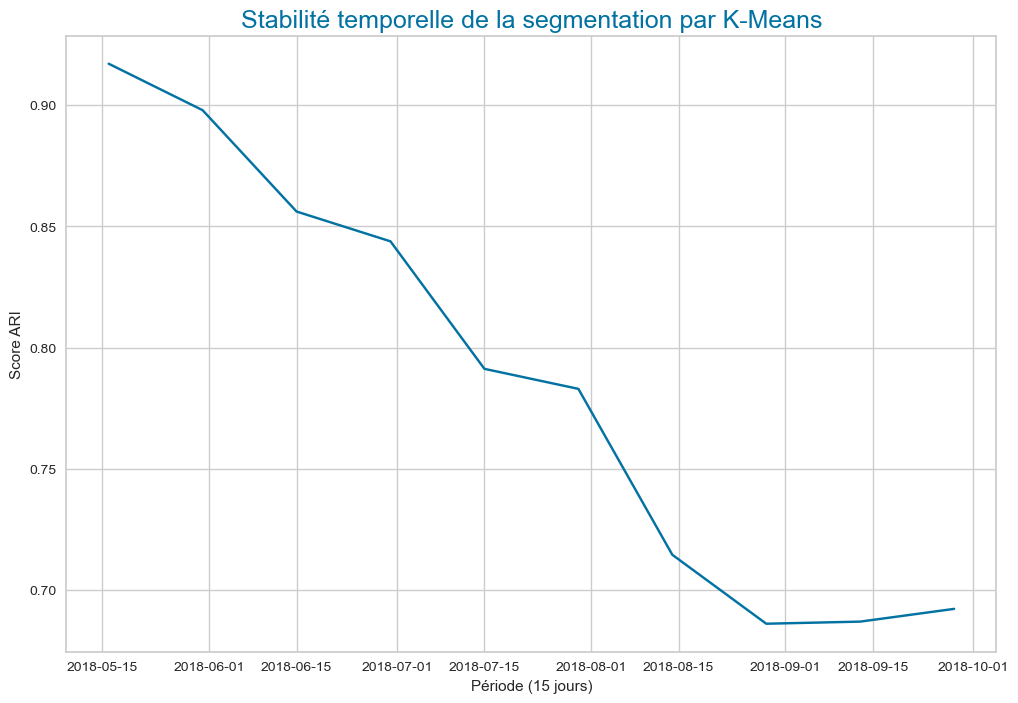

In [28]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (15 jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()